In [1]:
%matplotlib inline
from src.pgm import draw, discretize, get_f1_score

import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

from pgmpy.models import BayesianModel

In [2]:
df = pd.read_csv("dataset/diabetes.csv").astype({"Outcome": "category"})
kbd = KBinsDiscretizer(n_bins=5, encode='ordinal').fit(df.drop(columns="Outcome"))
df = discretize(kbd, df)
train, test = train_test_split(df, test_size=0.15, stratify=df["Outcome"], random_state=42)

/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


# Model uproszczony
Rozważamy tylko zmienne:
- Glucose
- Insulin
- SkinThickness
- Outcome

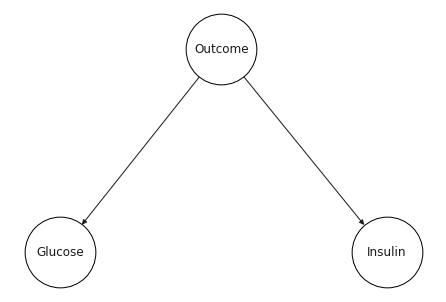

In [3]:
bn = BayesianModel([
    ("Outcome", "Glucose"),
    ("Outcome", "Insulin"),
])
bn.fit(train[["Glucose", "Insulin", "Outcome"]])
draw(bn)

In [4]:
y_pred = bn.predict(test[["Glucose", "Insulin"]])
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

100%|██████████| 14/14 [00:00<00:00, 106.86it/s]
F1-score: 0.43
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        76
           1       0.50      0.38      0.43        40

    accuracy                           0.66       116
   macro avg       0.60      0.59      0.59       116
weighted avg       0.64      0.66      0.64       116



# Pełen model
Wpierw badamy wyniki zwracane przez modele, których struktura wynika ze zgromadzonej wiedzy o problemie.
Wiemy, że cukrzycy 

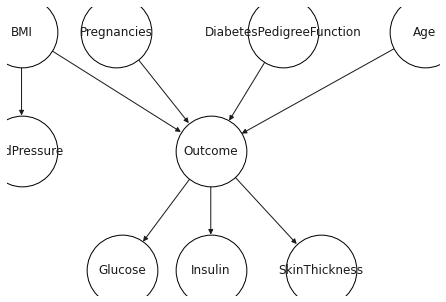

100%|██████████| 115/115 [00:01<00:00, 80.24it/s]
F1-score: 0.58
              precision    recall  f1-score   support

           0       0.78      0.79      0.78        76
           1       0.59      0.57      0.58        40

    accuracy                           0.72       116
   macro avg       0.68      0.68      0.68       116
weighted avg       0.71      0.72      0.71       116



In [5]:
bn = BayesianModel([
    ("BMI", "BloodPressure"),
    ("BMI", "Outcome"),
    ("Pregnancies", "Outcome"),
    ("DiabetesPedigreeFunction", "Outcome"),
    ("Age", "Outcome"),
    ("Outcome", "Glucose"),
    ("Outcome", "Insulin"),
    ("Outcome", "SkinThickness"),
])
bn.fit(train)
draw(bn)
y_pred = bn.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

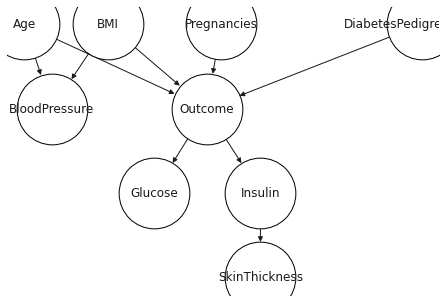

100%|██████████| 115/115 [00:02<00:00, 54.76it/s]
F1-score: 0.59
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        76
           1       0.57      0.60      0.59        40

    accuracy                           0.71       116
   macro avg       0.68      0.68      0.68       116
weighted avg       0.71      0.71      0.71       116



In [6]:
bn = BayesianModel([
    ("Age", "BloodPressure"),
    ("BMI", "BloodPressure"),
    ("BMI", "Outcome"),
    ("Pregnancies", "Outcome"),
    ("DiabetesPedigreeFunction", "Outcome"),
    ("Age", "Outcome"),
    ("Outcome", "Glucose"),
    ("Outcome", "Insulin"),
    ("Insulin", "SkinThickness"),
])
bn.fit(train)
draw(bn)
y_pred = bn.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

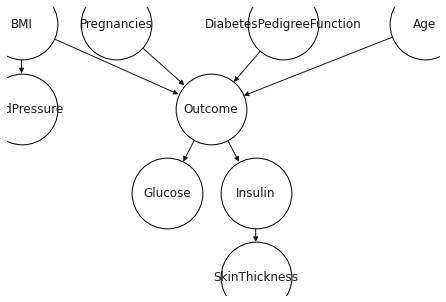

100%|██████████| 115/115 [00:01<00:00, 59.02it/s]
F1-score: 0.59
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        76
           1       0.57      0.60      0.59        40

    accuracy                           0.71       116
   macro avg       0.68      0.68      0.68       116
weighted avg       0.71      0.71      0.71       116



In [7]:
bn = BayesianModel([
    ("BMI", "BloodPressure"),
    ("BMI", "Outcome"),
    ("Pregnancies", "Outcome"),
    ("DiabetesPedigreeFunction", "Outcome"),
    ("Age", "Outcome"),
    ("Outcome", "Glucose"),
    ("Outcome", "Insulin"),
    ("Insulin", "SkinThickness"),
])
bn.fit(train)
draw(bn)
y_pred = bn.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

# Poszukiwanie architektury grafu

In [8]:
BayesianModel(list(bn.edges)).edges

OutEdgeView([('BMI', 'BloodPressure'), ('BMI', 'Outcome'), ('Outcome', 'Glucose'), ('Outcome', 'Insulin'), ('Insulin', 'SkinThickness'), ('Pregnancies', 'Outcome'), ('DiabetesPedigreeFunction', 'Outcome'), ('Age', 'Outcome')])

  0%|          | 6/1000000 [00:00<39:40:56,  7.00it/s]


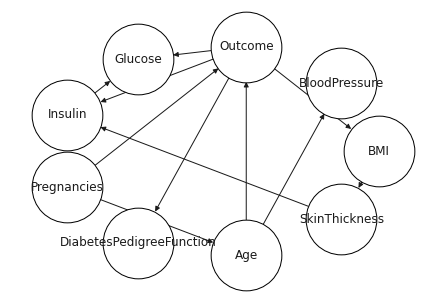

100%|██████████| 115/115 [00:00<00:00, 481.54it/s]
F1-score: 0.64
              precision    recall  f1-score   support

           0       0.81      0.80      0.81        76
           1       0.63      0.65      0.64        40

    accuracy                           0.75       116
   macro avg       0.72      0.73      0.72       116
weighted avg       0.75      0.75      0.75       116



In [9]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score
from copy import deepcopy


bn_hc = HillClimbSearch(df).estimate(
    scoring_method=K2Score(df),
    start_dag=BayesianModel(list(bn.edges)),
)
draw(bn_hc, layout="kamada_kawai_layout", scale=40);
model = bn_hc.copy()
model.fit(train)
y_pred = model.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

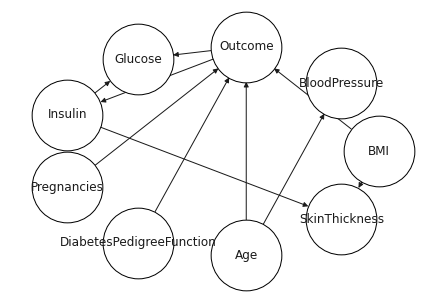

In [10]:
bn_hc.remove_edge("Outcome", "BMI")
bn_hc.add_edge("BMI", "Outcome")

bn_hc.remove_edge("SkinThickness", "Insulin")
bn_hc.add_edge("Insulin", "SkinThickness")

bn_hc.remove_edge("Outcome", "DiabetesPedigreeFunction")
bn_hc.add_edge("DiabetesPedigreeFunction", "Outcome")

bn_hc.remove_edge("Pregnancies", "Age")

draw(bn_hc, layout="kamada_kawai_layout", scale=40);

In [11]:
model = bn_hc.copy()
model.fit(train)
y_pred = model.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

100%|██████████| 115/115 [00:01<00:00, 58.40it/s]
F1-score: 0.58
              precision    recall  f1-score   support

           0       0.78      0.75      0.77        76
           1       0.56      0.60      0.58        40

    accuracy                           0.70       116
   macro avg       0.67      0.68      0.67       116
weighted avg       0.70      0.70      0.70       116



Working for n conditional variables: 2:  40%|████      | 2/5 [00:02<00:02,  1.29it/s]/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test Pregnancies ⟂ Outcome | Glucose=0, BMI=0. Not enough samples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test BMI ⟂ Outcome | SkinThickness=1, Age=0. Not enough samples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test BMI ⟂ Outcome | Glucose=0, Age=0. Not enough samples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test Pregnancies ⟂ Outcome | Glucose=0, Age=0. Not enough samples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test Age ⟂ Outcome | BMI=0, Pregnancies

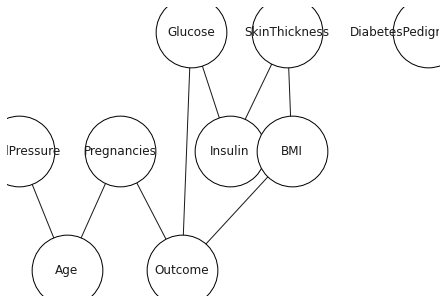

In [12]:
from pgmpy.estimators import PC
pc_est = PC(data=df)
skeleton_pc, separating_sets_pc = pc_est.build_skeleton(variant='parallel')
draw(skeleton_pc)

In [13]:
bn_pc = BayesianModel(list(skeleton_pc.edges))
bn_pc.add_nodes_from(bn)
bn_pc.fit(train)
y_pred = bn_pc.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

100%|██████████| 115/115 [00:00<00:00, 244.73it/s]
F1-score: 0.69
              precision    recall  f1-score   support

           0       0.84      0.83      0.83        76
           1       0.68      0.70      0.69        40

    accuracy                           0.78       116
   macro avg       0.76      0.76      0.76       116
weighted avg       0.79      0.78      0.79       116

